In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, astropy.coordinates as coord, astropy.units as u
from scipy.optimize import curve_fit
mpl.rcParams['font.family'] = 'serif'

In [2]:
main_sequence = pd.read_csv('HR-project-stars(1).csv')
white_dwarfs = pd.read_csv('wd-stars.csv')
color_scale = pd.read_csv('stars-color-color-diagrams (1).csv')
specClasses = list("OBAFGKM")

In [3]:
main_sequence['M(v)'] = main_sequence['Vmag'] + (5*np.log(main_sequence['Par(mas)']/100))
starlist = main_sequence.drop(['Unnamed: 7', 'Unnamed: 8'],axis=1)

init_max = max(starlist.index) # number of entries before added WD catalog

for i in white_dwarfs.index: # append corresponding columns from WDs to the main list
    main_i = i+init_max
    starlist.loc[main_i,'HIP id'] = white_dwarfs.loc[i,'|name'].split()[-1]
    starlist.loc[main_i,'Vmag'] = white_dwarfs.loc[i,'vmag']
    starlist.loc[main_i,'RA (deg)'] = white_dwarfs.loc[i,'ra']
    starlist.loc[main_i,'Dec (deg)'] = white_dwarfs.loc[i,'dec']
    starlist.loc[main_i,'(B-V)'] = white_dwarfs.loc[i,'bv_color']
    starlist.loc[main_i,'Sp class'] = white_dwarfs.loc[i,'spect_type'][:2]
    starlist.loc[main_i,'Par(mas)'] = white_dwarfs.loc[i,'parallax']
    starlist.loc[main_i,'M(v)'] = white_dwarfs.loc[i,'Mvmag']
    
starlist.rename(columns={'(B-V)': 'Color (B-V)'},inplace=True)

In [4]:
starlist['L/Ls'] = 2.512**(4.83 - starlist['M(v)'])

starlist

,HIP id,Vmag,RA (deg),Dec (deg),Par(mas),Color (B-V),Sp class,M(v),L/Ls
0,9884,2.01,31.79285757,23.46277743,49.48,1.150,K2III,-1.508008,343.026541
1,3419,2.04,10.89678452,-17.9866841,34.04,1.020,K0III,-3.348169,1868.221404
2,5447,2.07,17.43248991,35.62083048,16.36,1.580,M0IIIvar,-6.981654,53075.443549
3,3179,2.24,10.12661349,56.53740928,14.27,1.170,K0II-IIIvar,-7.495054,85165.463086
4,746,2.28,2.29204036,59.15021814,59.89,0.380,F2III-IV,-0.283303,111.025229
...,...,...,...,...,...,...,...,...,...
494,8709,12.44,01 52 02.9581,+47 00 05.582,63.08,0.170,DA,11.439458,0.002270
495,56662,12.49,11 37 05.2036,+29 47 58.391,65.28,-0.072,DA,11.563901,0.002024
496,107968,12.74,21 52 25.3700,+02 23 22.207,39.84,-0.011,DA,10.741597,0.004318
497,11650,12.79,02 30 16.5823,+05 15 50.906,41.15,-0.056,DA,10.861849,0.003865


In [5]:
#color_scale.drop(['log(tmp)-model'],axis=1,inplace=True)

logColorTemp = lambda BV,a0,a1,a2,a3,a4: a0+a1*(BV)+a2*(BV**2)+a3*(BV**3)+a4*(BV**4)
Ballesteros = lambda BV: 4600*(1/((0.92*BV)+1.7) + 1/((0.92*BV)+0.62))

guess_vals = [3.986,-0.558,0.498,-0.324,0.078]
fit_params, cov_mat = curve_fit(logColorTemp, color_scale['B-V'], color_scale['log(temp)'], p0=guess_vals)
fit_errors = np.sqrt(np.diag(cov_mat))

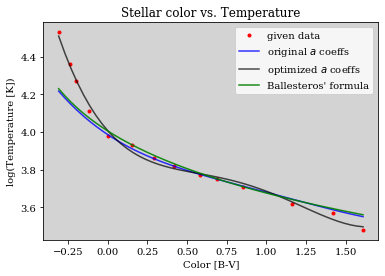

In [6]:
fig, ax = plt.subplots()
ax.set_facecolor('lightgrey')
plt.plot(color_scale['B-V'],color_scale['log(temp)'],'r.',label='given data')
plt.plot(np.linspace(-.31,1.61,50),logColorTemp(np.linspace(-.31,1.61,50),*guess_vals),'b-',label='original $a$ coeffs',alpha=0.8)
plt.plot(np.linspace(-.31,1.61,50),logColorTemp(np.linspace(-.31,1.61,50),*fit_params),'k-',label='optimized $a$ coeffs',alpha=0.7)
plt.plot(np.linspace(-.31,1.61,50),np.log10(Ballesteros(np.linspace(-.31,1.61,50))),'g-',label="Ballesteros' formula",alpha=0.9)
plt.xlabel('Color [B-V]')
plt.ylabel('log(Temperature [K])')
plt.title('Stellar color vs. Temperature')
plt.legend()
fig.savefig('colortemps.png',bbox_inches='tight')
plt.show()

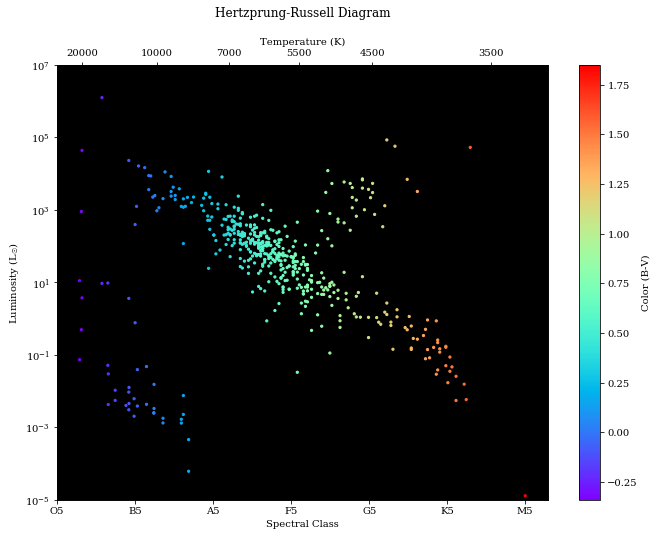

In [15]:
starlist['Temperature (K)'] = Ballesteros(starlist['Color (B-V)']) #or 10**logColorTemp(starlist['Color (B-V)'],*guess_vals)
HR = starlist.filter(['Color (B-V)','L/Ls','Temperature (K)'], axis=1)

fig, ax1 = plt.subplots()
ax1.set_facecolor('black')

ax2 = ax1.twiny()
tempColors = [-0.3729,0.01018,0.3779,0.7303,1.1068,1.7121] # these values have been pre-selected to give round Temp numbers
ax2.set_xticks([0.2+(color*0.4) for color in tempColors]) # align and place them in accordance with the main scale
tempLabels = [int(Ballesteros(color)) for color in tempColors] # calculate the temperatures
ax2.set_xticklabels(tempLabels)
ax2.set_xlabel('Temperature (K)')

HR.plot(figsize=(11,8),kind='scatter',x='Color (B-V)',y='L/Ls',c='Color (B-V)',
        cmap='rainbow',marker='.',logy=True,title='Hertzprung-Russell Diagram\n',
        ax=ax1).set(xlabel='Color (B-V)', ylabel='Luminosity (L$_\u2609$)')

ax1.set_xticks(np.linspace(-0.45,1.85,len(specClasses))) # approximate B-V values for each spectral class
ax1.set_xticklabels([Cl+'5' for Cl in specClasses])
ax1.set_xlabel('Spectral Class')

plt.gca().set_ylim(1e-5,1e7)
plt.show()
fig.savefig('diagram.png',bbox_inches='tight')

c:\users\caden gobat\appdata\local\programs\python\python36\lib\site-packages\matplotlib\projections\geo.py:414: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


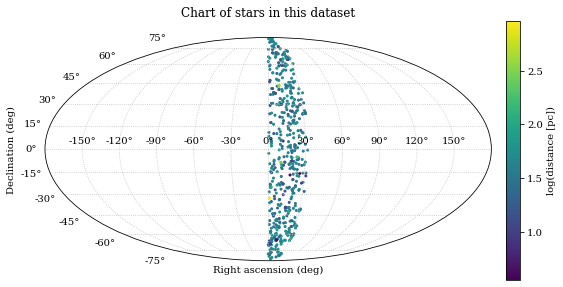

In [8]:
distances = 1/np.tan(starlist['Par(mas)']/1000)

ra = coord.Angle(starlist.loc[:,'RA (deg)'],unit=u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(starlist.loc[:,'Dec (deg)'],unit=u.degree)
fig, ax = plt.subplots(figsize=(8,6),subplot_kw={'projection': "mollweide"})
ax.grid(color='silver', linestyle=':')
skymap = ax.scatter(ra.radian, dec.radian,c=np.log10(distances),cmap='viridis',s=4) #*np.log10(distances)**2)

plt.title("Chart of stars in this dataset\n")
plt.xlabel("Right ascension (deg)")
plt.ylabel("Declination (deg)")

cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=min(np.log10(distances)), vmax=max(np.log10(distances)))
cax = fig.add_axes([0.925, 0.2, 0.025, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')
#cb.ax.set_yticklabels(lumClasses)
cb.set_label('log(distance [pc])')

plt.savefig('skymap.png',bbox_inches='tight')
plt.show()